In [1]:
import librosa   #for audio processing
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import wavfile #for audio processing
import warnings
warnings.filterwarnings("ignore")
import wave
import librosa.display
import sys, os
warnings.filterwarnings('ignore')

In [38]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))

"""from clean import Clean
from eda import EDA
cleaning_audios = Clean()"""


'from clean import Clean\nfrom eda import EDA\ncleaning_audios = Clean()'

In [54]:
train_dataset_location = '../data/train/'
train_wav_location = os.path.join(train_dataset_location, 'wav/')
train_changed_wav_location = os.path.join(train_dataset_location, 'converted_wavs/')
train_txt_location = os.path.join(train_dataset_location, 'trsTrain.txt')
test_dataset_location = 'test/' 
lexicon_location = 'train/'

In [56]:
train_file_names = os.listdir(train_wav_location)
train_wav_paths = [ os.path.join(train_wav_location, file_name)
                    for file_name in train_file_names]
print(f"There are {len(train_wav_paths)} Amharic wav files in the training set")

There are 10875 Amharic wav files in the training set


In [57]:
def tran_loader(filename):
    name_to_text = {}
    with open(filename, encoding="utf-8")as f:
        f.readline()
        for line in f:
            name = line.split("</s>")[1]
            name = name.replace('(', '')
            name = name.replace(')', '')
            name = name.replace('\n', '')
            name = name.replace(' ', '')
            text = line.split("</s>")[0]
            text = text.replace("<s>", "")
            name_to_text[name] = text
        return name_to_text

In [58]:
transcription = tran_loader(train_txt_location)

In [45]:
transcription

{'tr_2_tr01002': ' የተ ለቀቁት ምርኮኞች በ አካባቢያቸው ሰላማዊ ኑሮ እንዲ ኖሩ የ ትራንስፖርት ና መጓጓዣ ገንዘብ ተሰጥቷ ቸው መሸኘታቸው ን አመልክቶ በ የ ዞ ናቸው እንደ ደረሱ መቃቋሚያ እንደሚ ሰጣቸው ም አስ ታውቋል ',
 'tr_3_tr01003': ' በ አዲስ አበባው ስታዲየም በ ተካሄዱ ት ሁለት ግጥሚያ ዎች በ መጀመሪያ የ ተገናኙ ት መድን ና ሙገር ሲሚንቶ ሲ ሆኑ በ ውጤቱ ም ሶስት ለ ሶስት ተለያይ ተዋል ',
 'tr_4_tr01004': ' ወሬው ን ወሬ ያደረጉ ምስጢረ ኞች ናቸው ',
 'tr_5_tr01005': ' ኢትዮጵያዊ ቷ በ ብሄራዊ ባህላዊ አለባበስ ከ አለም አንደኝነት ን ተቀዳጀ ች ',
 'tr_6_tr01006': ' ከ ትምክህት እንዳይ ቆጠር ብን እንጂ በ አለም ታሪክ ውስጥ በ ነጮች ያል ተረገጠ ች አገር ኢትዮጵያ ና ት ',
 'tr_7_tr01007': ' እህቶቹ የኤርትራ ዜጐች ና የ ሻእቢያ ደጋፊዎች ናቸው ',
 'tr_8_tr01008': ' እናንተ ም መቀበሪያ እንዳ ታጡ ተጠንቀቁ ',
 'tr_9_tr01009': ' አንቶኔሊ በ አጼ ምንሊክ ፊት የ ፈጸመው ድፍረት በ ኢጣሊያ ን ምክር ቤት አስተ ቸው ',
 'tr_10_tr01010': ' ግን ወደ ኋላው ላይ ኢሳያስ እንደ ልማ ዳቸው ሁሉን ም የ መልከ ፍ ዲፕሎማሲ ያቸው እስራኤል ንም ያስ ወር ፋቸው ጀመር ',
 'tr_11_tr01011': ' ከ የ አቅጣጫ ው እየ ደረሷቸው ያሉ መረጃዎች አሳሳቢ ችግሮች እየ ደረሱ መሆናቸው ን የሚ ጠቁሙ መሆናቸው ን ፕሬዝዳንቱ ተናግረ ዋል ',
 'tr_12_tr01012': ' ከ ማወቁ በፊት እንደ ተበጠበጠ ገበያ እንዳይ በታተን ይህ ነው አጀንዳ ችን ሌላ አጀንዳ የ ለ ንም ',
 'tr_13_tr01013': ' ኢትዮጵያ ም ሰራዊቷ በ ኤርትራ እንደሚ 

In [59]:
import wave, array
def change_channel_to_stereo(file1, output):
    try:
        ifile = wave.open(file1)
        print(ifile.getparams())
        # (1, 2, 44100, 2013900, 'NONE', 'not compressed')
        (nchannels, sampwidth, framerate, nframes, comptype, compname) = ifile.getparams()
        assert comptype == 'NONE'  # Compressed not supported yet
        array_type = {1:'B', 2: 'h', 4: 'l'}[sampwidth]
        left_channel = array.array(array_type, ifile.readframes(nframes))[::nchannels]
        ifile.close()

        stereo = 2 * left_channel
        stereo[0::2] = stereo[1::2] = left_channel

        ofile = wave.open(output, 'w')
        ofile.setparams((2, sampwidth, framerate, nframes, comptype, compname))
        print(ofile.getnchannels())
        ofile.writeframes(stereo.tobytes())
        ofile.close()
        return ofile.getnchannels()
    except Exception as e:
        print(e)

In [60]:
def resize_audio(audio: np.array, size: int) -> np.array:
        
        resized = librosa.util.fix_length(audio, size, axis=1)
        print(f"Audio resized to {size} samples")
        return resized

In [61]:
# we will use the first wav file to visualize its characteristics
#librosa load returns by default time-series as numpy array and with the default sample rate of 22KHZ so we just changed it to 44kHZ
samples, sample_rate = librosa.load(train_wav_location+'tr_1_tr01001.wav' , sr=44100)
print(samples)
print(sample_rate)

[-0.00502738 -0.00588078 -0.00577551 ... -0.00516981 -0.00347923
  0.        ]
44100


In [62]:
# Top five mono files conv
for file_name in train_file_names[0:10]:
    change_channel_to_stereo(os.path.join(train_wav_location, file_name) , os.path.join(train_changed_wav_location, file_name))
     

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=145408, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=90112, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=98304, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=92160, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=86016, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=106496, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=104448, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=88064, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfram

In [3]:
#Display  samples and sample_rate 
rain_dataset_location = 'train/'
rain_wav_location = os.path.join(train_dataset_location, 'wav/')
train_file_names = os.listdir(train_wav_location)
train_audio_path = '../data_test/swahili_train_wav/SWH-05-20101106_16k-emission_swahili_05h30_-_06h00_tu_20101106_part3.wav'
samples, sample_rate = librosa.load(train_audio_path)

print(samples)
print(sample_rate)

[ 0.02666823  0.03076     0.02397061 ... -0.14377044 -0.1552949
 -0.09687205]
22050


In [4]:
#audio, rate=librosa.load('C:/Users/dell/Downloads/Compressed/AMHARIC/data/train/wav/tr_56_tr01056.wav')

In [5]:
ipd.Audio(samples, rate=sample_rate)

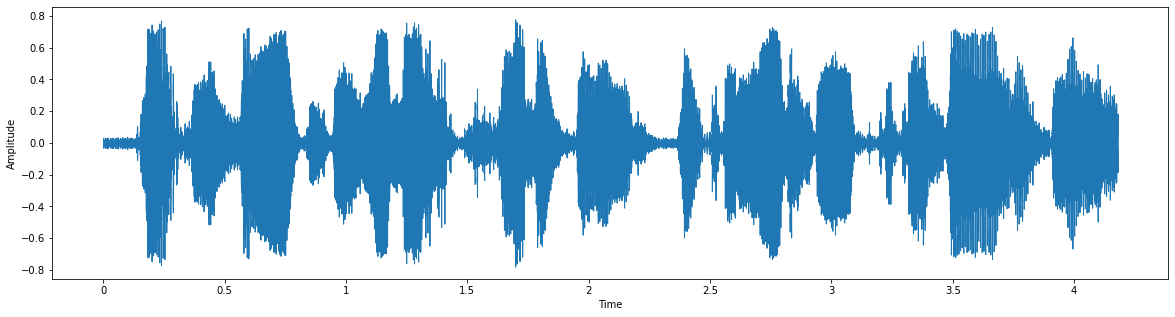

In [6]:
#plot our sample wav file 
%matplotlib inline

#Plot the signal:
plt.figure(figsize=(20, 5))
plt.xlabel("Time")
plt.ylabel('Amplitude')
librosa.display.waveshow(samples, sr=sample_rate)

In [7]:
from numpy.lib.stride_tricks import as_strided
def spectrogram(samples, fft_length=256, sample_rate=2, hop_length=128):
    """
    Compute the spectrogram for a real signal.
    The parameters follow the naming convention of
    matplotlib.mlab.specgram

    Args:
        samples (1D array): input audio signal
        fft_length (int): number of elements in fft window
        sample_rate (scalar): sample rate
        hop_length (int): hop length (relative offset between neighboring
            fft windows).

    Returns:
        x (2D array): spectrogram [frequency x time]
        freq (1D array): frequency of each row in x

    Note:
        This is a truncating computation e.g. if fft_length=10,
        hop_length=5 and the signal has 23 elements, then the
        last 3 elements will be truncated.
    """
    assert not np.iscomplexobj(samples), "Must not pass in complex numbers"

    window = np.hanning(fft_length)[:, None]
    window_norm = np.sum(window**2)

    # The scaling below follows the convention of
    # matplotlib.mlab.specgram which is the same as
    # matlabs specgram.
    scale = window_norm * sample_rate

    trunc = (len(samples) - fft_length) % hop_length
    x = samples[:len(samples) - trunc]

    # "stride trick" reshape to include overlap
    nshape = (fft_length, (len(x) - fft_length) // hop_length + 1)
    nstrides = (x.strides[0], x.strides[0] * hop_length)
    x = as_strided(x, shape=nshape, strides=nstrides)

    # window stride sanity check
    assert np.all(x[:, 1] == samples[hop_length:(hop_length + fft_length)])

    # broadcast window, compute fft over columns and square mod
    x = np.fft.rfft(x * window, axis=0)
    x = np.absolute(x)**2

    # scale, 2.0 for everything except dc and fft_length/2
    x[1:-1, :] *= (2.0 / scale)
    x[(0, -1), :] /= scale

    freqs = float(sample_rate) / fft_length * np.arange(x.shape[0])

    return x, freqs

In [8]:
spe_samples,frequency=spectrogram(samples)

In [9]:
frequency

array([0.       , 0.0078125, 0.015625 , 0.0234375, 0.03125  , 0.0390625,
       0.046875 , 0.0546875, 0.0625   , 0.0703125, 0.078125 , 0.0859375,
       0.09375  , 0.1015625, 0.109375 , 0.1171875, 0.125    , 0.1328125,
       0.140625 , 0.1484375, 0.15625  , 0.1640625, 0.171875 , 0.1796875,
       0.1875   , 0.1953125, 0.203125 , 0.2109375, 0.21875  , 0.2265625,
       0.234375 , 0.2421875, 0.25     , 0.2578125, 0.265625 , 0.2734375,
       0.28125  , 0.2890625, 0.296875 , 0.3046875, 0.3125   , 0.3203125,
       0.328125 , 0.3359375, 0.34375  , 0.3515625, 0.359375 , 0.3671875,
       0.375    , 0.3828125, 0.390625 , 0.3984375, 0.40625  , 0.4140625,
       0.421875 , 0.4296875, 0.4375   , 0.4453125, 0.453125 , 0.4609375,
       0.46875  , 0.4765625, 0.484375 , 0.4921875, 0.5      , 0.5078125,
       0.515625 , 0.5234375, 0.53125  , 0.5390625, 0.546875 , 0.5546875,
       0.5625   , 0.5703125, 0.578125 , 0.5859375, 0.59375  , 0.6015625,
       0.609375 , 0.6171875, 0.625    , 0.6328125, 

In [10]:
spe_samples

array([[1.36373824e-02, 1.68458917e-02, 3.84563660e-02, ...,
        1.05248268e-01, 4.88198083e-03, 1.22208309e-01],
       [2.07464198e-02, 2.56179762e-02, 3.76750487e-02, ...,
        7.91384135e-01, 3.63697518e-01, 7.31460708e-01],
       [1.80384582e-03, 1.09525856e-03, 2.69785761e-03, ...,
        1.14885237e+00, 4.42945456e-02, 6.15300287e-01],
       ...,
       [1.66475885e-15, 6.77365859e-17, 3.61396856e-16, ...,
        2.86604758e-15, 8.97511061e-16, 1.23193303e-15],
       [1.84672300e-15, 6.86886476e-18, 8.46600268e-18, ...,
        1.01819342e-14, 1.34004315e-15, 8.61738275e-15],
       [9.11512277e-16, 3.54341144e-17, 7.12756158e-17, ...,
        7.20771123e-16, 2.83362722e-16, 1.69225108e-15]])

In [11]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def plot_spectrogram_feature(vis_spectrogram_feature):
    # plot the normalized spectrogram
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(111)
    im = ax.imshow(vis_spectrogram_feature, cmap=plt.cm.jet, aspect='auto')
    plt.title('Spectrogram')
    plt.ylabel('Time')
    plt.xlabel('Frequency')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.show()

In [12]:
#function that load text file and change it to Dictionary 
def t_loader(filename):
  name_to_text = {}
  with open (filename, encoding="utf-8")as f:
    f.readline()
    for line in f:
          line = line.strip()
          alist = line.split(' ', 1)
          key, values = alist[0], alist[1:]
          str1 = ''.join(str(e) for e in values)
          name_to_text[key] = str1
  #print(values)
  return name_to_text

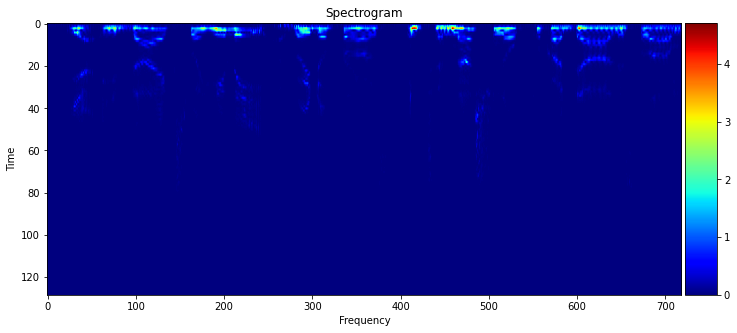

In [13]:
plot_spectrogram_feature(spe_samples)

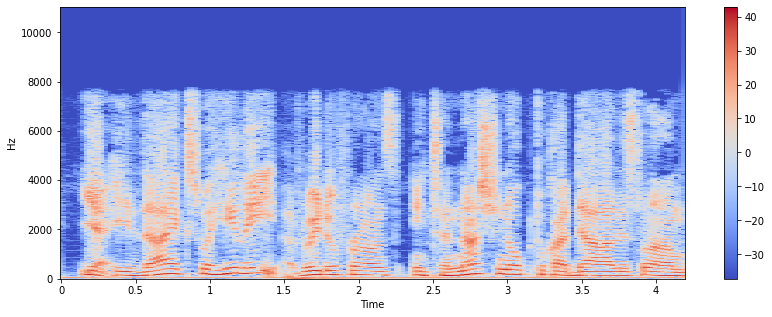

In [14]:
X = librosa.stft(samples)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sample_rate, x_axis='time', y_axis='hz')
plt.colorbar()

In [15]:
transcription=t_loader("../data_test/text_train_sw.txt")
transcription

{'SWH-05-20101106_16k-emission_swahili_05h30_-_06h00_tu_20101106_part100\tyanayo': 'andaliwa nami pendo pondo idhaa ya kiswahili',
 'SWH-05-20101106_16k-emission_swahili_05h30_-_06h00_tu_20101106_part101\tinayokutangazia': 'moja kwa moja kutoka jijini dar es salaam tanzania',
 'SWH-05-20101106_16k-emission_swahili_05h30_-_06h00_tu_20101106_part102\tjuma': 'hili bara la afrika limeshuhudia raia wa nchi za niger',
 'SWH-05-20101106_16k-emission_swahili_05h30_-_06h00_tu_20101106_part103\twakipiga': 'kura ya maoni ilikufanya mabadiliko ya',
 'SWH-05-20101106_16k-emission_swahili_05h30_-_06h00_tu_20101106_part104\tkule': 'abidjan raia wa jiji hilo',
 'SWH-05-20101106_16k-emission_swahili_05h30_-_06h00_tu_20101106_part105\twalipata': 'fursa ya kutumia haki yao ya msingi',
 'SWH-05-20101106_16k-emission_swahili_05h30_-_06h00_tu_20101106_part106\twaziri': 'mkuu wa zamani alasane watara',
 'SWH-05-20101106_16k-emission_swahili_05h30_-_06h00_tu_20101106_part107\tna': 'rais aliyetangulia henry ko

### mono to stereo conversion

In [18]:
import wave, array
def change_channel_to_stereo(file1, output):
    try:
        ifile = wave.open(file1)
        print(ifile.getparams())
        # (1, 2, 44100, 2013900, 'NONE', 'not compressed')
        (nchannels, sampwidth, framerate, nframes, comptype, compname) = ifile.getparams()
        assert comptype == 'NONE'  # Compressed not supported yet
        array_type = {1:'B', 2: 'h', 4: 'l'}[sampwidth]
        left_channel = array.array(array_type, ifile.readframes(nframes))[::nchannels]
        ifile.close()

        stereo = 2 * left_channel
        stereo[0::2] = stereo[1::2] = left_channel

        ofile = wave.open(output, 'w')
        ofile.setparams((2, sampwidth, framerate, nframes, comptype, compname))
        print(ofile.getnchannels())
        ofile.writeframes(stereo.tobytes())
        ofile.close()
        return ofile.getnchannels()
    except Exception as e:
        print(e)

In [ ]:
for file_name in train_file_names[0:10]:
    change_channel_to_stereo(os.path.join(train_wav_location, file_name) , os.path.join(train_changed_wav_location, file_name))

In [20]:
change_channel_to_stereo("../data_test/swahili_train_wav/SWH-05-20101106_16k-emission_swahili_05h30_-_06h00_tu_20101106_part2.wav", "../gen_data/SWH-05-20101106_16k2.wav")

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=71520, comptype='NONE', compname='not compressed')
2


2

### Sampling Rate Standardization

In [21]:
from scipy.io import wavfile as wav

In [22]:
## Read the stereo dat asampling
fullpath  = '../gen_data/SWH-05-20101106_16k2.wav'

librosa_load, librosa_sampling_rate = librosa.load(fullpath)

scipy_sampling_rate, scipy_load = wav.read(fullpath)

## convert the sampling rate
print('original sample rate:',scipy_sampling_rate)
print('converted sample rate:',librosa_sampling_rate)
print('\n')
print('original wav file min~max range:',np.min(scipy_load),'~',np.max(scipy_load))
print('converted wav file min~max range:',np.min(librosa_load),'~',np.max(librosa_load))

original sample rate: 16000
converted sample rate: 22050


original wav file min~max range: -24720 ~ 24457
converted wav file min~max range: -0.7695227 ~ 0.7539317


In [23]:
###   data befor and after sampling rate conversion

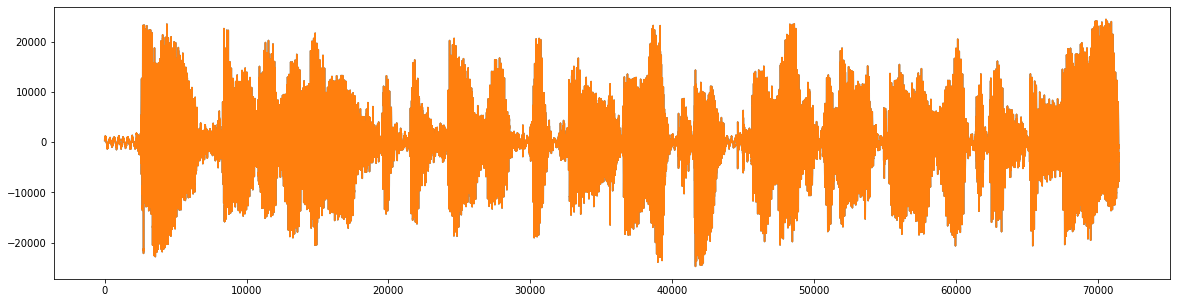

In [24]:
plt.figure(figsize=(20, 5))
plt.plot(scipy_load)

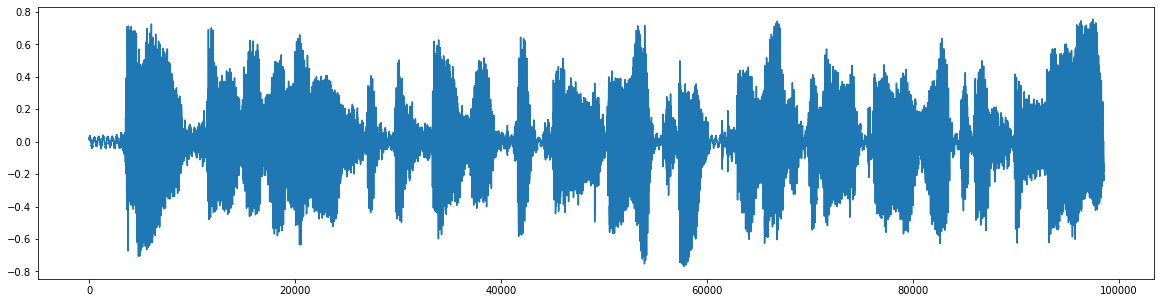

In [25]:
plt.figure(figsize=(20, 5))
plt.plot(librosa_load)

In [32]:
# Resize
def resize_audio(audio: np.array, size: int) -> np.array:
        """
        This resizes all input audio to a fixed sample size.
        It helps us to have a consistent data shape

        Args:
            audio: This is the audio sample as a numpy array
        """
        resized = librosa.util.fix_length(audio, size, axis=1)
        print(f"Audio resized to {size} samples")
        return resized

In [26]:
def meta_data(trans, path ):
  target=[]
  features=[]
  filenames=[]
  duration_of_recordings=[]
  for k in trans:
    filename=path+k +".wav"
    filenames.append(filename)
    audio, fs = librosa.load(filename, sr=None)
    duration_of_recordings.append(float(len(audio)/fs))
   
    lable = trans[k]
    target.append(lable)
  return filenames, target,duration_of_recordings

In [27]:
#export data to csv and save as dataS.csv 
import csv
with open('../data_test/data_sw.csv', 'w') as f:
    for key in transcription.keys():
        f.write("%s,%s\n"%(key,transcription[key]))

### Data Augumentation Swahili

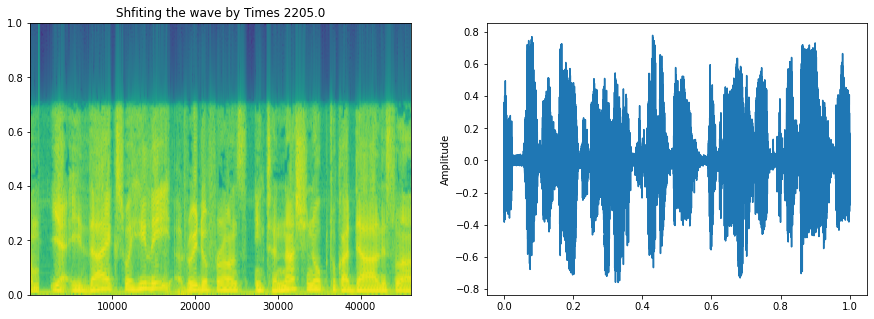

In [28]:
def plot_spec(data:np.array,sr:int) -> None:
  '''
  Function for plotting spectrogram along with amplitude wave graph
  '''
  
  fig, ax = plt.subplots(1,2,figsize=(15,5))
  ax[0].title.set_text(f'Shfiting the wave by Times {sr/10}')
  ax[0].specgram(data,Fs=2)
  ax[1].set_ylabel('Amplitude')
  ax[1].plot(np.linspace(0,1,len(data)), data)

wav_roll = np.roll(samples,int(sample_rate/10))
plot_spec(data=wav_roll,sr=sample_rate)
ipd.Audio(wav_roll,rate=sample_rate)

(20, 181)


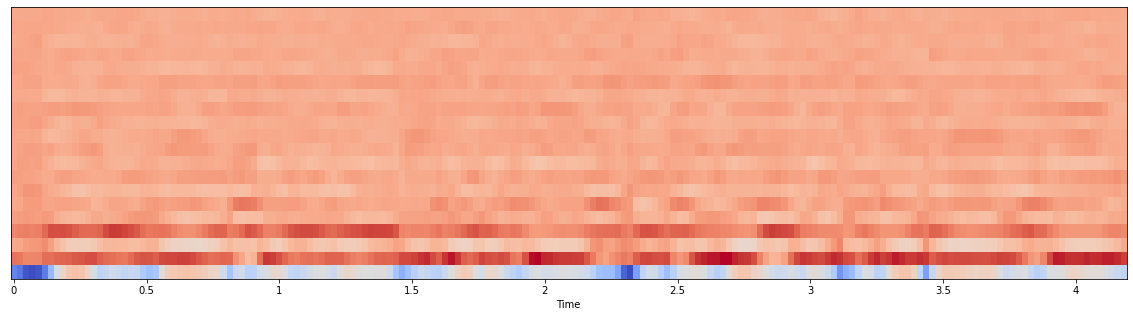

In [29]:
# MFCC
plt.figure(figsize=(20,5))
mfccs = librosa.feature.mfcc(samples, sr=sample_rate)
print(mfccs.shape)

librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time')

In [30]:
mata_data_path = '../dat_test/metadata.csv'

In [31]:
meta_data = pd.read_csv(mata_data_path)

FileNotFoundError: [Errno 2] No such file or directory: '../dat_test/metadata.csv'